In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def simulate_F(futures_price, volatility_true, risk_free_rate, time_to_maturity, paths = 100000):
    '''
    Monte Carlo simulation
    return futures price array, the corresponding time to maturity array, and the time step
    '''
    # initialize vectors
    steps = int(252*time_to_maturity) # daily simulation
    arr_F = np.zeros((paths, steps))
    arr_F[:,0] = futures_price

    # generate Brownian motion
    arr_w = np.random.standard_normal(size = (paths, steps-1))

    # compute the corresponding price
    arr_t, dt = np.linspace(0, time_to_maturity, steps, retstep=True)
    arr_F[:,1:] = np.exp( -0.5 * volatility_true**2 * dt + volatility_true * dt**0.5 * arr_w )
    arr_F = np.cumprod(arr_F, axis = 1)
    arr_tau = time_to_maturity - arr_t # array broadcasting
    arr_tau = np.zeros(arr_F.shape) + arr_tau

    return arr_F, arr_tau, dt


def black_call(arr_futures_price, strike_price, volatility_call, volatility_delta, risk_free_rate, arr_time_to_maturity):
    '''
    Black formula
    return call option price array and corresponding delta array
    '''
    # divide by zero issue
    arr_m_call = np.log(arr_futures_price[:,:-1] / strike_price) / (volatility_call * arr_time_to_maturity[:,:-1]**0.5)
    arr_call_partial = np.exp(-risk_free_rate * arr_time_to_maturity[:,:-1]) * (arr_futures_price[:,:-1] * norm.cdf(arr_m_call + 0.5 * volatility_call * arr_time_to_maturity[:,:-1]**0.5) -
                                                                                strike_price * norm.cdf(arr_m_call - 0.5 * volatility_call * arr_time_to_maturity[:,:-1]**0.5))
    arr_call = np.hstack((arr_call_partial, np.expand_dims(np.maximum(0, arr_futures_price[:,-1] - strike_price), axis = 1)))

    arr_m_delta = np.log(arr_futures_price[:,:-1] / strike_price) / (volatility_delta * arr_time_to_maturity[:,:-1]**0.5)
    arr_delta_partial = np.exp(-risk_free_rate * arr_time_to_maturity[:,:-1]) * norm.cdf(arr_m_delta + 0.5 * volatility_delta * arr_time_to_maturity[:,:-1]**0.5)
    arr_delta = np.hstack((arr_delta_partial, np.expand_dims((arr_futures_price[:,-1]>100) + np.zeros(paths,), axis = 1)))

    return arr_call, arr_delta



In [3]:
# Parameters
futures_price = 100
strike_price = 100
risk_free_rate = 0.05
time_to_maturity = 1.0
paths = 100000

def simulate_PnL(vol_true, vol_delta, vol_market, n = 20):
    '''
    Monte Carlo simulation and generate cumulative PnL plot
    return futures price array, call option price array, delta array, daily PnL array, cumulative PnL array, time to maturity array, and the time step
    '''
    arr_F, arr_tau, dt = simulate_F(futures_price, vol_true, risk_free_rate, time_to_maturity, paths)
    arr_call, arr_delta = black_call(arr_F, strike_price, vol_market, vol_delta, risk_free_rate, arr_tau)
    arr_dailyPnL = (arr_call[:,1:] - arr_call[:,:-1]) - arr_delta[:,:-1] * (arr_F[:,1:] - arr_F[:,:-1]) - risk_free_rate * arr_call[:,:-1] * dt
    arr_cumPnL = np.hstack((np.zeros((paths,1)), arr_dailyPnL.cumsum(axis = 1)))
    arr_dailyPnL = np.hstack((np.zeros((paths,1)), arr_dailyPnL))

    plt.figure(figsize=(8, 6))
    for tau, cumPnL in zip(arr_tau[:n], arr_cumPnL[:n]):
        plt.plot(tau, cumPnL[::-1], linewidth=1.2)
    plt.title(f'Delta hedging (vol_true = {vol_true}, vol_delta = {vol_delta}, vol_market = {vol_market})')
    plt.xlabel('time'); plt.ylabel('cumulative PnL'); plt.ylim([-2,7])

    plt.show()

    return (arr_F, arr_call, arr_delta, arr_dailyPnL, arr_cumPnL, arr_tau, dt)

## Case 1: $ \sigma_{true} > \sigma_{delta} = \sigma_{market} $

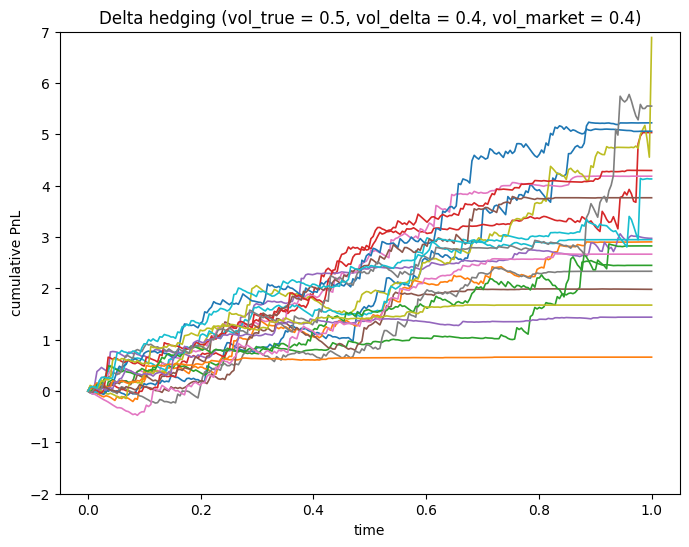

In [4]:
# volatility
vol_true = 0.5
vol_delta = 0.4
vol_market = 0.4

result = simulate_PnL(vol_true, vol_delta, vol_market)

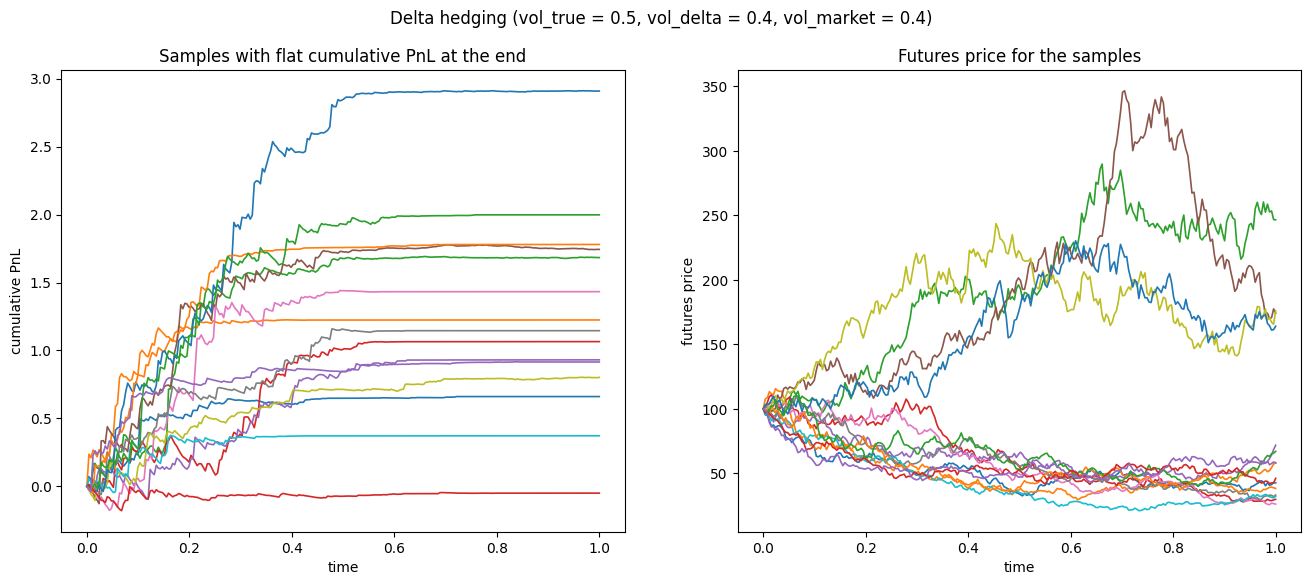

In [5]:
# Examine the samples with flat cumulative PnL at the end
num_sample_to_plot = 15
index = result[3][:,int(252*time_to_maturity)//2:].std(axis = 1) < 0.005


plt.figure(figsize=(16, 6))
plt.suptitle(f'Delta hedging (vol_true = {vol_true}, vol_delta = {vol_delta}, vol_market = {vol_market})')

plt.subplot(121)
for tau, cumPnL in zip(result[5][index, :][:num_sample_to_plot], result[4][index, :][:num_sample_to_plot]):
    plt.plot(tau, cumPnL[::-1], linewidth=1.2)
    plt.title(f'Samples with flat cumulative PnL at the end')
    plt.xlabel('time'); plt.ylabel('cumulative PnL')

plt.subplot(122)
for tau, cumPnL in zip(result[5][index, :][:num_sample_to_plot], result[0][index, :][:num_sample_to_plot]):
    plt.plot(tau, cumPnL[::-1], linewidth=1.2)
    plt.title(f'Futures price for the samples')
    plt.xlabel('time'); plt.ylabel('futures price')

plt.show()

## Case 2: $ \sigma_{true} = \sigma_{delta} > \sigma_{market} $

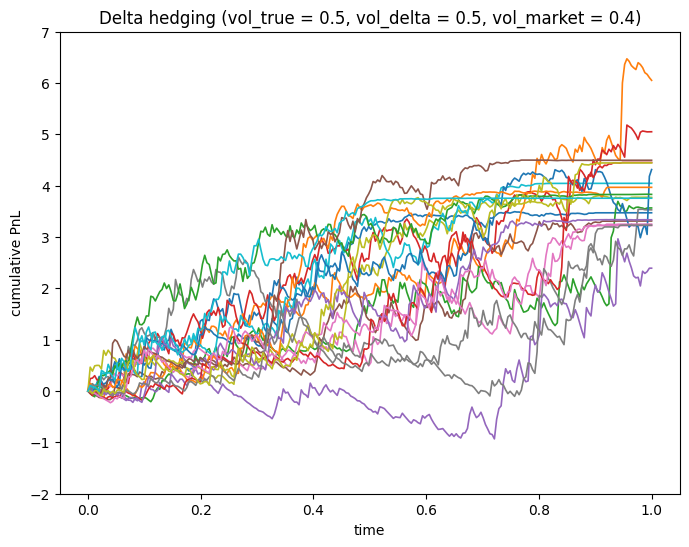

In [6]:
# volatility
vol_true = 0.5
vol_delta = 0.5
vol_market = 0.4

result = simulate_PnL(vol_true, vol_delta, vol_market)

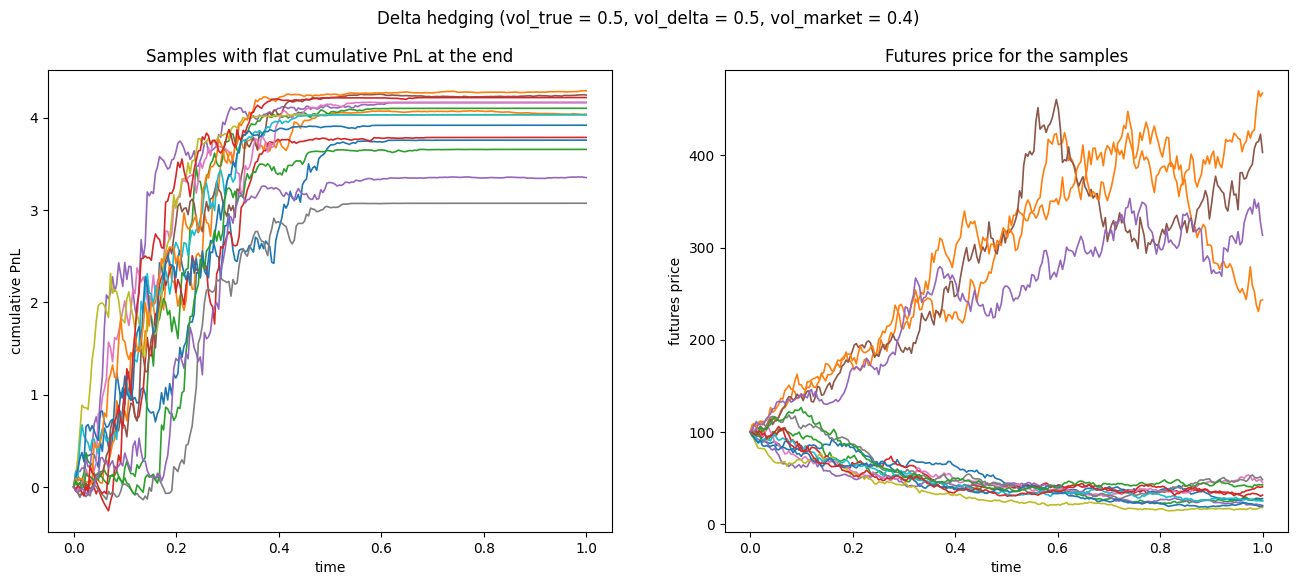

In [7]:
# Examine the samples with flat cumulative PnL at the end
num_sample_to_plot = 15
index = result[3][:,int(252*time_to_maturity)//2:].std(axis = 1) < 0.005


plt.figure(figsize=(16, 6))
plt.suptitle(f'Delta hedging (vol_true = {vol_true}, vol_delta = {vol_delta}, vol_market = {vol_market})')

plt.subplot(121)
for tau, cumPnL in zip(result[5][index, :][:num_sample_to_plot], result[4][index, :][:num_sample_to_plot]):
    plt.plot(tau, cumPnL[::-1], linewidth=1.2)
    plt.title(f'Samples with flat cumulative PnL at the end')
    plt.xlabel('time'); plt.ylabel('cumulative PnL')

plt.subplot(122)
for tau, cumPnL in zip(result[5][index, :][:num_sample_to_plot], result[0][index, :][:num_sample_to_plot]):
    plt.plot(tau, cumPnL[::-1], linewidth=1.2)
    plt.title(f'Futures price for the samples')
    plt.xlabel('time'); plt.ylabel('futures price')

plt.show()

## Case 3: $ \sigma_{true} = \sigma_{delta} = \sigma_{market} $

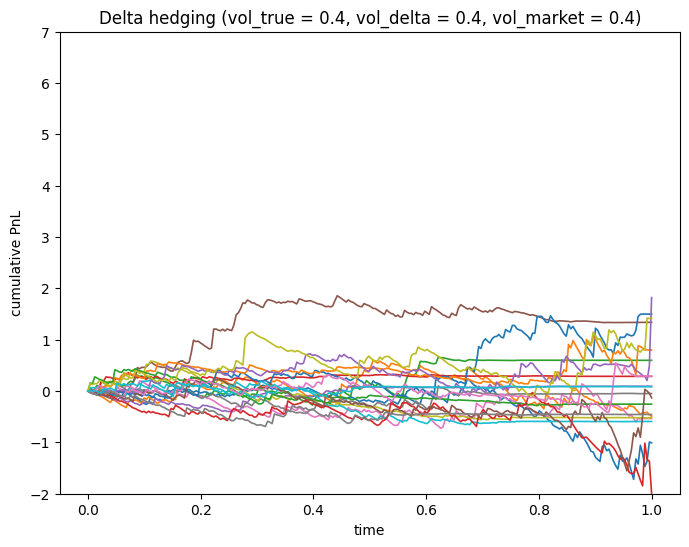

In [8]:
# volatility
vol_true = 0.4
vol_delta = 0.4
vol_market = 0.4

result = simulate_PnL(vol_true, vol_delta, vol_market)

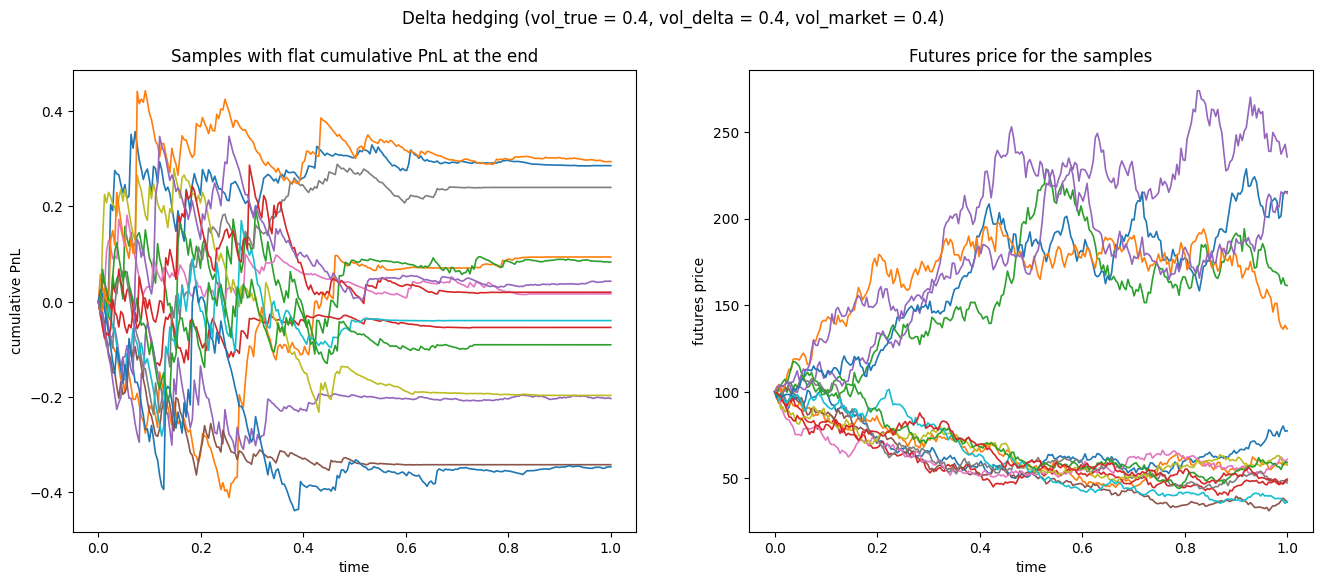

In [9]:
# Examine the samples with flat cumulative PnL at the end
num_sample_to_plot = 15
index = result[3][:,int(252*time_to_maturity)//2:].std(axis = 1) < 0.005


plt.figure(figsize=(16, 6))
plt.suptitle(f'Delta hedging (vol_true = {vol_true}, vol_delta = {vol_delta}, vol_market = {vol_market})')

plt.subplot(121)
for tau, cumPnL in zip(result[5][index, :][:num_sample_to_plot], result[4][index, :][:num_sample_to_plot]):
    plt.plot(tau, cumPnL[::-1], linewidth=1.2)
    plt.title(f'Samples with flat cumulative PnL at the end')
    plt.xlabel('time'); plt.ylabel('cumulative PnL')

plt.subplot(122)
for tau, cumPnL in zip(result[5][index, :][:num_sample_to_plot], result[0][index, :][:num_sample_to_plot]):
    plt.plot(tau, cumPnL[::-1], linewidth=1.2)
    plt.title(f'Futures price for the samples')
    plt.xlabel('time'); plt.ylabel('futures price')

plt.show()

In [10]:
# Examine the samples with daily PnL jumps
num_sample_to_plot = 15
index = np.abs(result[3]) > 0.5

df = pd.DataFrame({'daily PnL':result[3][index],
                   'futures price':result[0][index],
                   'time to maturity': result[5][index]})

print(df.describe().loc['mean',:])

daily PnL             0.658647
futures price       101.369739
time to maturity      0.109975
Name: mean, dtype: float64
